In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# 数据读取和查看

In [2]:
data = pd.read_csv(r'F:\pythoncode\Hands on machine learning\Hands on machine learning\ML-project\信用卡欺诈检测建模\creditcard.csv')

In [3]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


1、 查看交易的类别,1表示欺诈交易，0表示正常交易，类别数量相差非常大，预处理时需要进行采样

In [4]:
data['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [5]:
count_classes = data['Class'].value_counts()

Text(0, 0.5, 'Frequence')

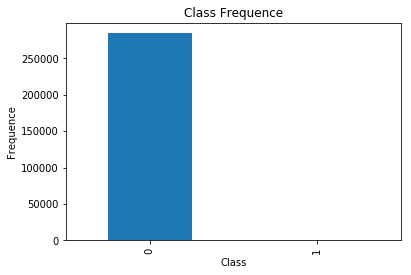

In [6]:
count_classes.plot(kind='bar')
plt.title('Class Frequence')
plt.xlabel('Class')
plt.ylabel('Frequence')

# 数据预处理

1、划分训练集和验证集

In [7]:
from sklearn.model_selection import train_test_split

X = data.drop('Class',axis=1)
y = data['Class']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=0)
y_train = y_train.reset_index(drop=True)

2、标准化处理

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

3、进行数据欠采样

In [9]:
# 训练集中欺诈和正常实例的索引
fraud_indices = np.array(y_train[y_train == 1].index)
normal_indices = np.array(y_train[y_train == 0].index)

# 训练集中欺诈实例个数
fraud_number = len(y_train[y_train == 1])

# 在正常实例中随机采样
random_normal_indices = np.random.choice(normal_indices,fraud_number,replace=False)
random_normal_indices = np.array(random_normal_indices)

# 欠采样后训练集
under_sample_indices = np.concatenate([fraud_indices,random_normal_indices])
X_train_undersample = X_train_scaled[under_sample_indices,:]
y_train_undersample = y_train[under_sample_indices]

# 模型训练与评估

1、训练逻辑回归模型

In [30]:
# 利用交叉验证训练模型
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score,recall_score

param_grid = {'C':[0.001,0.01,0.1,1,10,100]}
grid_search = GridSearchCV(LogisticRegression(solver='liblinear'),param_grid,cv=5)
grid_search.fit(X_train_undersample,y_train_undersample)
print('最佳超参数C:{}'.format(grid_search.best_params_))

final_model = grid_search.best_estimator_
final_prediction = final_model.predict(X_test_scaled)
print('逻辑回归召回率:{:.2f}'.format(recall_score(y_test,final_prediction)))

最佳超参数C:{'C': 0.01}
逻辑回归召回率:0.93


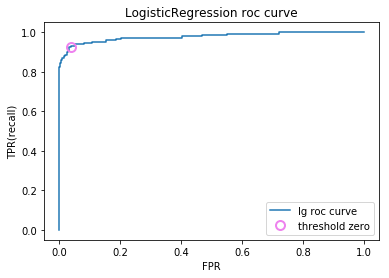

In [44]:
# 绘制ROC曲线
from sklearn.metrics import roc_curve

FPR,TPR,thresholds = roc_curve(y_test,final_model.decision_function(X_test_scaled))
plt.plot(FPR,TPR,label='lg roc curve')
plt.title('LogisticRegression roc curve')
plt.xlabel('FPR')
plt.ylabel('TPR(recall)')
close_zero = np.argmin(np.abs(thresholds))
plt.plot(FPR[close_zero],TPR[close_zero],'o',markersize=9,label='threshold zero',fillstyle='none',c='violet',mew=2)
plt.legend(loc='best')

In [37]:
# 计算逻辑回归AUC
from sklearn.metrics import roc_auc_score

lg_auc = roc_auc_score(y_test,final_model.decision_function(X_test_scaled))
print('逻辑回归AUC：{:.3f}'.format(lg_auc))

逻辑回归AUC：0.978


2、训练支持向量机模型

In [40]:
# 利用交叉验证训练模型
from sklearn.svm import SVC

param_grid = {'C':[0.001,0.01,0.1,1,10,100],'gamma':[0.001,0.01,0.1,1,10,100]}
grid_search = GridSearchCV(SVC(),param_grid,cv=5)
grid_search.fit(X_train_undersample,y_train_undersample)
print('最佳超参数C,gamma：{}'.format(grid_search.best_params_))

final_model_svm = grid_search.best_estimator_
final_prediction_svm = final_model_svm.predict(X_test_scaled)
print('支持向量机召回率：{:.2f}'.format(recall_score(y_test,final_prediction_svm)))

最佳超参数C,gamma：{'C': 1, 'gamma': 0.01}
支持向量机召回率：0.89


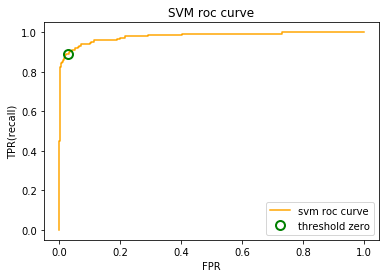

In [49]:
# 绘制ROC曲线
FPR,TPR,thresholds = roc_curve(y_test,final_model_svm.decision_function(X_test_scaled))
plt.plot(FPR,TPR,label='svm roc curve',c='orange')
plt.title('SVM roc curve')
plt.xlabel('FPR')
plt.ylabel('TPR(recall)')
close_zero = np.argmin(np.abs(thresholds))
plt.plot(FPR[close_zero],TPR[close_zero],'o',markersize=9,label='threshold zero',fillstyle='none',c='g',mew=2)
plt.legend(loc='best')

In [50]:
# 计算支持向量机AUC
svm_auc = roc_auc_score(y_test,final_model_svm.decision_function(X_test_scaled))
print('支持向量机AUC:{:.3f}'.format(svm_auc))

支持向量机AUC:0.980


3、逻辑回归和支持向量机的AUC分别是0.978和0.98，对数据都有较好的拟合。